In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection
matplotlib.rcParams.update({'font.size': 16})

import naima

import astropy.units as u
from astropy.units import Quantity, Unit
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion

import csv

In [2]:
from gammapy.modeling.models import Models, NaimaSpectralModel, SkyModel

from gammapy.data import DataStore
from gammapy.data import EventList

from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    FoVBackgroundMaker,
    AdaptiveRingBackgroundMaker,
    RingBackgroundMaker
)

from gammapy.irf import (
    Background3D,
    EnergyDispersion2D,
    EffectiveAreaTable2D                      
)

from gammapy.data import (
    Observation,
    HDUIndexTable,
)

from gammapy.maps import Map, MapAxis, WcsGeom,RegionGeom

from gammapy.datasets import (
    MapDataset,
    MapDatasetOnOff,
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    LogParabolaSpectralModel,
    ExpDecayTemporalModel,
    ExpCutoffPowerLawSpectralModel,
    GaussianTemporalModel,
    SineTemporalModel,
    PowerLawTemporalModel
)

from gammapy.visualization import (
    plot_theta_squared_table,
    plot_spectrum_datasets_off_regions
)

from gammapy.makers.utils import make_theta_squared_table


from gammapy.estimators import (
    TSMapEstimator,
    ExcessMapEstimator,
    LightCurveEstimator,
    FluxPointsEstimator,
    FluxPoints,
    SensitivityEstimator
)

from gammapy.stats import (
    WStatCountsStatistic
)

In [3]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [4]:
#load IRFs
file="CTAN-IRFs/CTA-Performance-prod5-v0.1-North-20deg.FITS/"+\
        "Prod5-North-20deg-SouthAz-4LSTs09MSTs.1800s-v0.1.fits.gz"

Aeff = EffectiveAreaTable2D.read(file)
Edisp = EnergyDispersion2D.read(file,hdu='ENERGY DISPERSION')
Bkg = Background3D.read(file)

irfs_dict = {
  "aeff": Aeff,
  "bkg": Bkg,
  "edisp": Edisp
}
irfs_dict

#DL3 analysis, specifications
e_reco_sensitivity = MapAxis.from_energy_bounds(
    0.02, 100, nbin=5, per_decade=True, unit="TeV", name="energy"
)
on_region_radius = Angle("0.2 deg")
pointing = SkyCoord.from_name("V339Del")
offset = 0.5 * u.deg
center = pointing.directional_offset_by(position_angle=0 * u.deg, separation=offset)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)
sensitivity_geom = RegionGeom.create(region=on_region, axes=[e_reco_sensitivity])
energy_axis_true_sensitivity = e_true = MapAxis.from_energy_bounds(
    0.01, 200, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

In [5]:
t_interval = np.linspace(1,60*2,60*2)*u.min
gti_t_ref = Time("2020-03-01T02:00:00.0")# yyyy-mm-dd Thh:mm:ss

table_sensitivity=[]
for t_int in t_interval:
    sensitivity_obs = Observation.create(irfs=irfs_dict,
                             pointing=pointing, 
                             livetime=t_int,
                             tstart=0*u.s,
                             reference_time=gti_t_ref,
                             obs_id=0)


    spectrum_maker = SpectrumDatasetMaker(
        selection=["exposure", "edisp", "background"]
    )

    sensitivity_dataset_empty = SpectrumDataset.create(geom=sensitivity_geom,
                                                     name="sensitivity")

    sensitivity_dataset = spectrum_maker.run(sensitivity_dataset_empty, sensitivity_obs)


    sensitivity_dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=sensitivity_dataset, acceptance=1, acceptance_off=3
    )


    diff_sensitivity=SensitivityEstimator(spectrum=PowerLawSpectralModel(index=4,
                                                                         amplitude="1e-10 cm-2 s-1 TeV-1"))
                                                                         #spectrum=sim_model.spectral_model)
    table=diff_sensitivity.run(sensitivity_dataset_on_off)
    table_sensitivity.append(table)
    
    
sensitivity_plot=np.ones((len(t_interval),len(table_sensitivity[0]),2))

for y,table in enumerate(table_sensitivity):
    for i,value in enumerate(table):
        sensitivity_plot[y,i,0]=value["energy"]
        sensitivity_plot[y,i,1]=value["e2dnde"]    

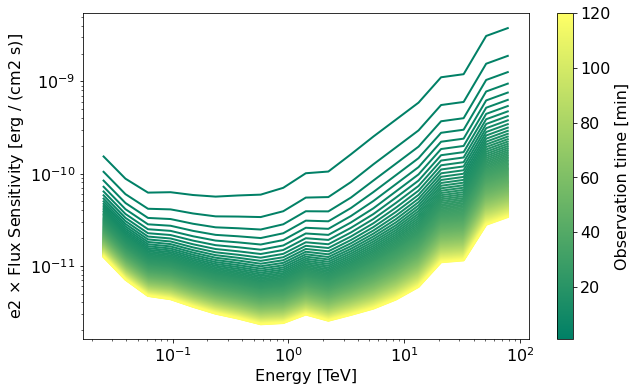

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Energy [{}]".format(table_sensitivity[0]["energy"].unit))
ax.set_ylabel(r"e2 $\times$ Flux Sensitivity [{}]".format(table_sensitivity[0]["e2dnde"].unit))
axcb = fig.colorbar(lc)

axcb.set_label('Observation time [min]')

In [7]:
def funct_nej(mej,vej):
    n_ej=6e8*((mej/1e-6)*(vej/4500)**(-3))
    return n_ej

def funct_nRG(mrate,vej,vRG):
    n_RG=1.1e8*((mrate/5e-7)*(vej/4500)**(-2)*(vRG/10)**(-1))
    return n_RG
    
mej=3e-5
vej=3000
print("n_ej={:1.1e}".format(funct_nej(mej,vej)))

mrate=1e-6
vej=4500
vRG=10
print("n_RG={:1.1e}".format(funct_nRG(mrate,vej,vRG)))

n_ej=6.1e+10
n_RG=2.2e+08


## Change different target proton number density

(1e-13, 1e-09)

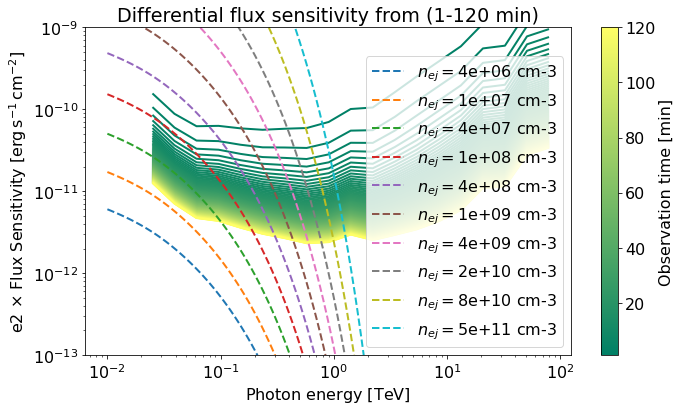

In [8]:
#same part. dist. and dist. Different nej
fig, ax = plt.subplots(figsize=(10,6))
energy_range = np.logspace(10,13,100)*u.eV

lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
axcb = fig.colorbar(lc)
axcb.set_label('Observation time [min]')

#RS Oph particle dist
part_dist=naima.models.ExponentialCutoffPowerLaw(
    amplitude=8e31 / u.eV,
    e_0=130*u.GeV,
    alpha=2.44,
    e_cutoff=280*u.GeV
)

mej=np.geomspace(1e-8,1e-5,10)
vej=np.linspace(5000,1000,10)
for nej_i in funct_nej(mej,vej):
    rad_models = naima.models.PionDecay(part_dist, nh=nej_i * u.cm ** -3)
    sed=rad_models.sed(energy_range, distance=1.4 * u.kpc)

    plt.loglog(energy_range.to("TeV"), sed, label=r"$n_{{ej}}=${:1.0e} cm-3".format(nej_i), ls ="--", lw=2)
    
plt.title("Differential flux sensitivity from (1-120 min)") 
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Photon energy [{0}]'.format(
        energy_range.to("TeV").unit.to_string('latex_inline')))
plt.ylabel(r'e2 $\times$ Flux Sensitivity [{0}]'.format(
        sed.unit.to_string('latex_inline')))
plt.tight_layout()
plt.legend(loc='lower right')
plt.ylim((1e-13,1e-9))

## Change distance

(1e-13, 1e-09)

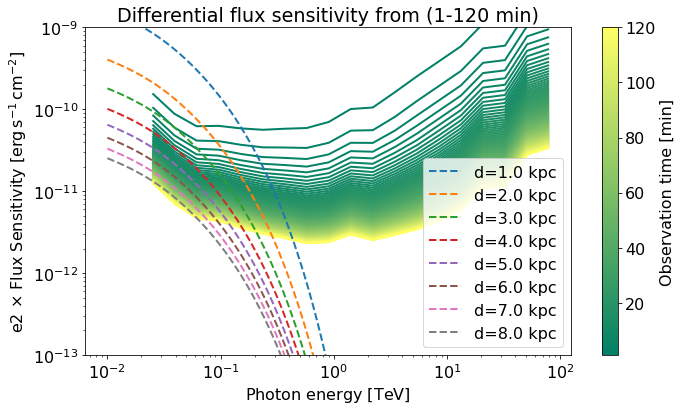

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
energy_range = np.logspace(10,12,100)*u.eV

lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
axcb = fig.colorbar(lc)
axcb.set_label('Observation time [min]')

#same part dist. Different dist.
dist=np.linspace(1,8,8)*u.kpc

#RS Oph particle dist
part_dist=naima.models.ExponentialCutoffPowerLaw(
    amplitude=8e31 / u.eV,
    e_0=130*u.GeV,
    alpha=2.44,
    e_cutoff=280*u.GeV
)

for dist_i in dist:
    #RS Oph target proton number density
    rad_models = naima.models.PionDecay(part_dist, nh=6e8 * u.cm ** -3)
    sed=rad_models.sed(energy_range, distance=dist_i)

    plt.loglog(energy_range.to("TeV"), sed, label="d={:1.1f}".format(dist_i), ls ="--", lw=2)
    
plt.title("Differential flux sensitivity from (1-120 min)")    
plt.yscale("log")
plt.xscale("log")    
plt.xlabel('Photon energy [{0}]'.format(
        energy_range.to("TeV").unit.to_string('latex_inline')))
plt.ylabel(r'e2 $\times$ Flux Sensitivity [{0}]'.format(
        sed.unit.to_string('latex_inline')))
plt.ylim((1e-13,1e-9))
plt.tight_layout()
plt.legend(loc='lower right')
plt.ylim((1e-13,1e-9))

## Change energy exponential cutoff

(1e-13, 1e-09)

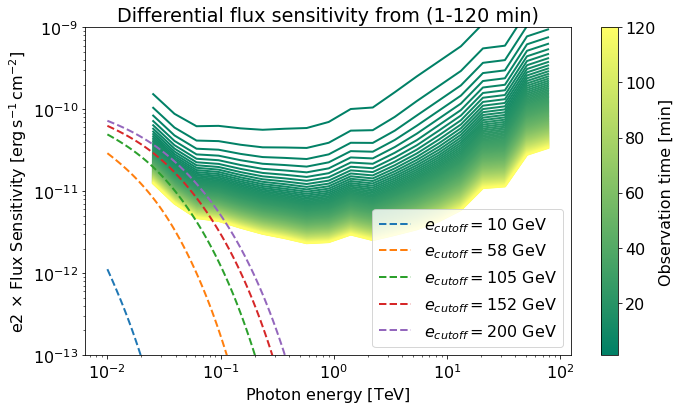

In [10]:
#same nej and dist. Different part. dist.
fig, ax = plt.subplots(figsize=(10,6))
energy_range = np.logspace(10,12,100)*u.eV

lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
axcb = fig.colorbar(lc)
axcb.set_label('Observation time [min]')

ecutoff=np.linspace(10,200,5)
for ecutoff_i in ecutoff:
    part_dist=naima.models.ExponentialCutoffPowerLaw(
        amplitude=1e31 / u.eV,
        e_0=130*u.GeV,
        alpha=2.3,
        e_cutoff=ecutoff_i*u.GeV
    )
    
    rad_models = naima.models.PionDecay(part_dist, nh=6e8 * u.cm ** -3)
    sed=rad_models.sed(energy_range, distance=1.5 * u.kpc)

    plt.loglog(energy_range.to("TeV"), sed, label=r"$e_{{cutoff}}={:1.0f}$ GeV".format(ecutoff_i), ls ="--", lw=2)

plt.title("Differential flux sensitivity from (1-120 min)")
plt.yscale("log")
plt.xscale("log")    
plt.xlabel('Photon energy [{0}]'.format(
        energy_range.to("TeV").unit.to_string('latex_inline')))
plt.ylabel(r'e2 $\times$ Flux Sensitivity [{0}]'.format(
        sed.unit.to_string('latex_inline')))
plt.tight_layout()
plt.legend(loc='lower right')
plt.ylim((1e-13,1e-9))


# Grid particle distribution from Fermi novae to RS Oph


Fermi novae proton particle distribution and n_ej (using MAGIC paper):
- V407 Cyg => sp: 1.4+0.3−0.4, ecutoff=10+1.0−0.7 GeV, F=4.05+0.26−0.37 e-7. nej=1.7e+09 cm-3
- V1324 Sco => sp: 2.6+0.2−0.7, ecutoff= > 32 GeV, F=4.25+0.54−0.77 e-7. nej=5.1e+10 cm-3
- V959 Mon => sp: 2.4+0.9−1.4, ecutoff= > 3.2 GeV, F=3.66+0.44−0.46 e-7. nej=1.2e+11 cm-3
- V339 Del => sp: 2.6+0.5−0.8, ecutoff= > 10 GeV, F=1.75+0.23−0.20 e-7. nej=5.5e+11 cm-3
- V1369 Cen => sp: 3.0+0.9-0.4, ecutoff= >10 GeV, F=1e-7. nej=6e+11 cm-3 (approx)
- V5668 Sag => sp: 3.1+0.3-0.9, ecutoff= >10 GeV, F=0.8e-7. nej=6e+11 cm-3 (approx)

RS Oph proton particle distribution and n_ej:
-  sp: 2.21 ± 0.08, ecutoff=257 ± 45 GeV. nej=6e+8 cm-3

I interpolate the particle distrubution from parameter values like the ones from Fermi novae to RS Oph

-  keeping fixed the spectral index to -2.
- I assume as the target proton number density for the pion decay radiative model the number density of the ejecta, which I interpolate from the values of n_ej of the Fermi novae to RS Oph using a shell shape (MAGIC paper)
- To reduce the parameters space, I assume: the particle amplitude and cutoff energy increase as the number density of the ejecta decreases (as see between Fermi novae and RS Oph)


In [11]:
ecutoff=np.geomspace(10,300,10)
A=np.geomspace(1e28,1e32,10)
nej=np.geomspace(5e11,5e8,10)
distance_array=np.arange(1,9)
energy_range = np.logspace(10,12,100)*u.eV
%matplotlib inline

SED_array=np.zeros((np.shape(distance_array)[0],np.shape(ecutoff)[0],np.shape(energy_range)[0]))

for cont1,d in enumerate(distance_array):
    
#uncomment to plot       
#     fig, ax = plt.subplots(figsize=(14,10))

    for cont2,(ecutoff_i,nej_i,A_i) in enumerate(zip(ecutoff,nej,A)):

        part_dist=naima.models.ExponentialCutoffPowerLaw(
            amplitude=A_i / u.eV,
            e_0=130*u.GeV,
            alpha=2,
            e_cutoff=ecutoff_i*u.GeV
        )

        
        rad_models = naima.models.PionDecay(part_dist, nh=nej_i * u.cm ** -3)
        sed=rad_models.sed(energy_range, distance=d * u.kpc)
        
        SED_array[cont1,cont2,:]=sed
        
#uncomment to plot      
#         plt.loglog(energy_range.to("TeV"), 
#                    sed, 
#                    label=r"$e_{{c}}={:1.0f}$ GeV, A={:1.1e} eV-1, $n_{{ej}}={:1.0e}$ cm-3".format(ecutoff_i,A_i,nej_i), ls ="--", lw=2)

        
#     lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
#     axcb = fig.colorbar(lc)
#     axcb.set_label('Observation time [min]')        
        
#     plt.title("Differential flux sensitivity from (1-120 min) - d={} kpc".format(d))        
#     plt.yscale("log")
#     plt.xscale("log")
#     plt.xlabel('Photon energy [{0}]'.format(
#             energy_range.to("TeV").unit.to_string('latex_inline')))
#     plt.ylabel(r'e2 $\times$ Flux Sensitivity [{0}]'.format(
#             sed.unit.to_string('latex_inline')))
#     plt.tight_layout()
#     plt.legend(loc="lower right",prop={'size': 14})
#     plt.ylim((1e-13,1e-9))
#     plt.ylabel(r"e2 $\times$ Flux Sensitivity [erg/(cm2 s)]")
# #     plt.savefig("../diff_sensitivity_d-{}kpc_ecutoff-{:1.0f}GeV_A-{:1.1e}ev-1_nej-{:1.0e}cm-3.png".format(d,ecutoff_i,A_i,nej_i),dpi=250)
#     plt.show()


interactive(children=(IntSlider(value=4, description='dist', max=8, min=1), Output()), _dom_classes=('widget-i…

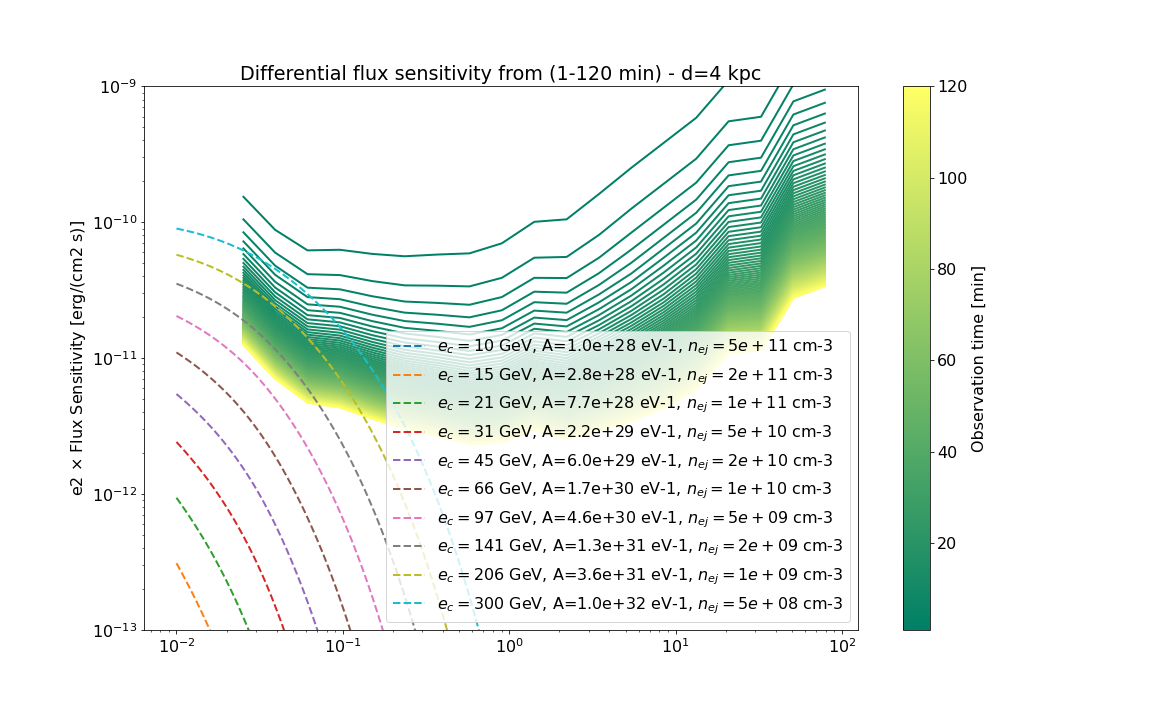

In [12]:
from ipywidgets import interact
%matplotlib widget
from tqdm.auto import tqdm
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(16,10))

lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
axcb = fig.colorbar(lc)
axcb.set_label('Observation time [min]')

       
plt.yscale("log")
plt.xscale("log")
plt.ylim((1e-13,1e-9))
plt.ylabel(r"e2 $\times$ Flux Sensitivity [erg/(cm2 s)]")

sup_e=np.ones((len(energy_range),len(A)))
for y in range(len(A)):
    sup_e[:,y]=energy_range.to("TeV")

lines = ax.plot(sup_e, 
                np.zeros(np.shape(sup_e)))


def plot_grid(dist):
    for i,line_k in enumerate(lines):
        line_k.set_data(energy_range.to("TeV"),SED_array[dist-1,i,:])
        ax.set_title("Differential flux sensitivity from (1-120 min) - d={} kpc".format(dist)) 
        line_k.set_label(r"$e_{{c}}={:1.0f}$ GeV, A={:1.1e} eV-1, $n_{{ej}}={:1.0e}$ cm-3".format(ecutoff[i],A[i],nej[i]))
        line_k.set_ls("--")
        line_k.set_lw(2)
    ax.legend(loc="lower right")
interact(plot_grid, dist=(1, 8));


### Find the values of $M_{WD}$, $T_{WD}$ and $\log{(\dot{M_{WD}})}$ consistent with the "nova model" at the limit of the sensitivity for 2 hours for different distances

Load tables from Yaron et al. 2005

Since RS Oph has the lowest n_ej, which I assume to be the target proton number density, models with lower number densities than the number density of the limit SED ($n_{lim}$) for a given distance will be observed by CTAN.

Thus: find $M_{WD}$, $T_{WD}$ and $\log{(\dot{M_{WD}})}$ that give lower number densities than $n_{lim}$

In [13]:
vmax_array=[]
vavg_array=[]
Mwd=[]
Twd=[]
logMdot=[]
with open("Yaron_vej_novae.txt") as tsv:
    for i,line in enumerate(csv.reader(tsv, dialect="excel-tab")): 
        if i!=0:
            vmax_array.append(line[3])
            vavg_array.append(line[4])
            logMdot.append(float(line[2]))
            if len(line[0])==0:
                Mwd.append(Mwd[-1])
                Twd.append(Twd[-1])
            else:
                Mwd.append(float(line[0]))
                Twd.append(float(line[1]))

In [14]:
mej_array=[]

with open("Yaron_mej_novae.txt") as tsv:
    for i,line in enumerate(csv.reader(tsv, dialect="excel-tab")): 
        if i!=0:
            mej_array.append(line[4])

In [15]:
for list_ in [vmax_array,vavg_array,mej_array]:
    for i,val in enumerate(list_):
        if val =="\\ldots":
            list_[i]=None
        else:
            list_[i]=float(val)

In [16]:
#specify the proton target density used for the novae and the distance at which this model is at the sens. limit
nh_lim_array=np.array([2e10,1e10,5e9,2e9,2e9,1e9,5e8])
for d,nh_lim in zip(distance_array[:len(nh_lim_array)+1],nh_lim_array):

    mask_visNovae=[]
    for m,v in zip(mej_array,vmax_array):
        if v!=None and m!=None and v!=0.0:
            if funct_nej(m,v)<=nh_lim:
                mask_visNovae.append(True)
            else:
                mask_visNovae.append(False)
        else:
            mask_visNovae.append(False)

    mask_visNovae=np.array(mask_visNovae)

    print("Combinations that survive in Yaron_2005_ApJ_623_398 for d={} kpc:".format(d))
    for m,T,lMd in zip(np.array(Mwd)[mask_visNovae],np.array(Twd)[mask_visNovae],np.array(logMdot)[mask_visNovae]):

        print("Mwd={}, Twd={}, logMdot={}".format(m,T,lMd))
    print( )

Combinations that survive in Yaron_2005_ApJ_623_398 for d=1 kpc:
Mwd=1.25, Twd=10.0, logMdot=-12.0
Mwd=1.25, Twd=30.0, logMdot=-12.0
Mwd=1.25, Twd=30.0, logMdot=-12.3
Mwd=1.25, Twd=50.0, logMdot=-12.3
Mwd=1.4, Twd=10.0, logMdot=-7.0
Mwd=1.4, Twd=10.0, logMdot=-8.0
Mwd=1.4, Twd=10.0, logMdot=-9.0
Mwd=1.4, Twd=10.0, logMdot=-10.0
Mwd=1.4, Twd=10.0, logMdot=-11.0
Mwd=1.4, Twd=30.0, logMdot=-7.0
Mwd=1.4, Twd=30.0, logMdot=-8.0
Mwd=1.4, Twd=30.0, logMdot=-9.0
Mwd=1.4, Twd=30.0, logMdot=-10.0
Mwd=1.4, Twd=30.0, logMdot=-11.0
Mwd=1.4, Twd=30.0, logMdot=-12.0
Mwd=1.4, Twd=50.0, logMdot=-7.0
Mwd=1.4, Twd=50.0, logMdot=-8.0
Mwd=1.4, Twd=50.0, logMdot=-9.0
Mwd=1.4, Twd=50.0, logMdot=-10.0
Mwd=1.4, Twd=50.0, logMdot=-11.0
Mwd=1.4, Twd=50.0, logMdot=-12.0

Combinations that survive in Yaron_2005_ApJ_623_398 for d=2 kpc:
Mwd=1.25, Twd=10.0, logMdot=-12.0
Mwd=1.25, Twd=30.0, logMdot=-12.3
Mwd=1.4, Twd=10.0, logMdot=-7.0
Mwd=1.4, Twd=10.0, logMdot=-8.0
Mwd=1.4, Twd=10.0, logMdot=-9.0
Mwd=1.4, Twd=10.0

# Simulations for a nova with a given particle distribution (the one at the limit of 2h sensitivity)


- Repeat 100 times 15 min run for 2 hours, no temporal model.
- Same IRFs

Obtain the distribution of Li&Ma significance (eq. 17) for run-wise data and 2 hours stacked data

In [17]:
#set spectral model
part_dist=naima.models.ExponentialCutoffPowerLaw(
    amplitude=1e32 / u.eV,
    e_0=130*u.GeV,
    alpha=2,
    e_cutoff=300*u.GeV
)

rad_models = naima.models.PionDecay(part_dist, nh=5e8 * u.cm ** -3)
spec_model = NaimaSpectralModel(rad_models, distance=8 * u.kpc)
sim_model=SkyModel(spectral_model=spec_model, name="lim_nova")

In [18]:
#load IRFs
file="CTAN-IRFs/CTA-Performance-prod5-v0.1-North-20deg.FITS/"+\
        "Prod5-North-20deg-SouthAz-4LSTs09MSTs.1800s-v0.1.fits.gz"

Aeff = EffectiveAreaTable2D.read(file)
Edisp = EnergyDispersion2D.read(file,hdu='ENERGY DISPERSION')
Bkg = Background3D.read(file)

irfs_dict = {
  "aeff": Aeff,
  "bkg": Bkg,
  "edisp": Edisp
}
irfs_dict

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x16c0f4ac0>,
 'bkg': <gammapy.irf.background.Background3D at 0x16bedffa0>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x16c303340>}

In [19]:
#DL3 analysis, specifications
e_reco = MapAxis.from_energy_bounds(
    0.02, 1, nbin=5, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = e_true = MapAxis.from_energy_bounds(
    0.01, 50, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)
on_region_radius = Angle("0.2 deg")
pointing = SkyCoord.from_name("V407 Cyg")
offset = 0.5 * u.deg
center = pointing.directional_offset_by(position_angle=0 * u.deg, separation=offset)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)
geom = RegionGeom.create(region=on_region, axes=[e_reco])


#specify the observations
t_int = 15*u.min
gti_t_ref = Time("2020-03-01T02:00:00.0")# yyyy-mm-dd Thh:mm:ss

sim_obs_array=[]
for i in range(int(((2*u.h).to("min")/(15*u.min)).value)):
    sim_obs = Observation.create(irfs=irfs_dict,
                         pointing=pointing, 
                         livetime=t_int,
                         tstart=(i*t_int).to("s"),
                         reference_time=gti_t_ref,
                         obs_id=0)
    sim_obs_array.append(sim_obs)
print("num of runs: ",len(sim_obs_array))

num of runs:  8


In [20]:
# Make the SpectrumDataset and maker
simulated_dataset_empty = SpectrumDataset.create(geom=geom,
                                                 name="sim")

maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

In [21]:
%%time

shortobs_LiMa_sig_array=[]
stackedobs_LiMa_sig_array=[]
ntimes=50

for n in range(ntimes):

    short_datasets=Datasets()
    for contador,sim_obs in enumerate(sim_obs_array):
        dataset_empty=simulated_dataset_empty.copy(name="obs_{}".format(contador))
        short_dataset = maker.run(dataset_empty, sim_obs)

        #set skymodel
        short_dataset.models = sim_model

        #fake signal
        short_dataset.fake()

        short_datasets.append(short_dataset) 


    short_datasets_on_off=Datasets()

    for obs in short_datasets:
        dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
            dataset=obs, acceptance=1, acceptance_off=3)

        # overwrite counts and off-counts with the fake method 
        dataset_on_off.fake(npred_background=obs.npred_background())
        short_datasets_on_off.append(dataset_on_off)

    short_datasets_on_off.models=None #I remove the model because if a model is set, the wstat computes 
                    #the statistics with that model. Then, the wstat changes with respect to the Li&Ma TS value
        
    shortobs_LiMa_sig_array=np.concatenate((shortobs_LiMa_sig_array, 
                                            short_datasets_on_off.info_table()["sqrt_ts"].value), axis=None)

    stacked_datasets_on_off=Datasets(short_datasets_on_off.stack_reduce())
    stackedobs_LiMa_sig_array.append(stacked_datasets_on_off.info_table()["sqrt_ts"].value[0])

CPU times: user 1min 15s, sys: 182 ms, total: 1min 15s
Wall time: 1min 15s


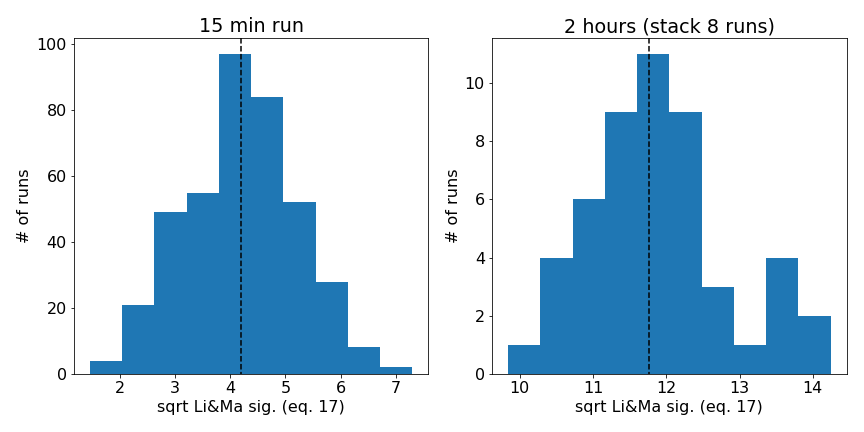

In [22]:
#plot
fig,axs=plt.subplots(1,2,figsize=(12,6))

axs[0].hist(shortobs_LiMa_sig_array)
axs[0].set_title("15 min run")
axs[0].set_ylabel("# of runs")
axs[0].set_xlabel("sqrt Li&Ma sig. (eq. 17)")
ymax,ymin=axs[0].set_ylim()
axs[0].vlines(np.median(shortobs_LiMa_sig_array),ymin,ymax, zorder=100, color="k", ls="--", label="median")


axs[1].hist(stackedobs_LiMa_sig_array)
axs[1].set_title("2 hours (stack 8 runs)")
axs[1].set_ylabel("# of runs")
axs[1].set_xlabel("sqrt Li&Ma sig. (eq. 17)")
ymax,ymin=axs[1].set_ylim()
axs[1].vlines(np.median(stackedobs_LiMa_sig_array),ymin,ymax, zorder=100, color="k", ls="--", label="median")

plt.tight_layout()
# plt.savefig("../hist_Li&MaSig_nsim-15min_tobs-{}_{}.png".format(ntimes,"d-8kpc"),dpi=250)